In [23]:
# IMPORTS
import matplotlib.pyplot as plt
import numpy as np
import csv 
import networkx as nx
from random import sample
import time
import math
import random

In [138]:
# Define necessary functions

def arccosh_og(x):  ##note that x*x-1 might be less than zero :( And then log(t) could be negative (negative distance?!?!?!?!)
    t = x + math.sqrt(x * x - 1)
    return math.log(t)

def arccosh(x):
    t = x + math.sqrt(max(x * x, 1) - 1)
    return max(math.log(t), 0.5)
    
def query(coordinates, source, destination, curvature):
    
    if source == destination:
        return 0
    
    sourceCoords = coordinates[source]
    destinationCoords = coordinates[destination]

    i = 0
    ts = 1.0
    td = 1.0
    tt = 1.0

    for i in range(len(sourceCoords)):
        ts += math.pow(sourceCoords[i], 2)
        td += math.pow(destinationCoords[i], 2)
        tt += (sourceCoords[i] * destinationCoords[i])
    #print(ts, td, tt)
    t = math.sqrt(ts * td) - tt
    #print('t:', t)
    return arccosh(t) * math.fabs(curvature)

## Barabasi Albert random graph for testing

In [2]:
# Barabasi Albert graph for test

np.random.seed(1337)

N = 1000
m1 = 15
m2 = 3
p = 0.1

G = nx.generators.random_graphs.dual_barabasi_albert_graph(N,m1,m2,p)


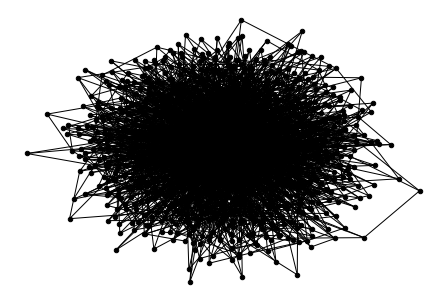

In [3]:
# show graph to get an idea
options = {
     'node_color': 'black',
     'node_size': 20,
     'width': 1,
    }

nx.draw(G, font_weight='bold', **options)
plt.show()


In [9]:
# save the file edgelist for later reconciliation

nx.write_edgelist(G, "graph_barabasi.edgelist")

In [4]:
#preparing inputs for rigel
landmark_cnt = 100
landmarks = sample(list(G.nodes()), landmark_cnt)
distance_matrix = [[-1 for i in range(N)] for j in range(landmark_cnt)]
for i in range(landmark_cnt):
    node = landmarks[i]
    path_lengths = nx.single_source_shortest_path_length(G, node)
    for j in range(N):
        distance_matrix[i][j] = int(path_lengths[j])

In [5]:
# write out input for Rigel
mat = np.matrix(distance_matrix)
with open('l1.txt','wb') as f:
    for line in mat:
        np.savetxt(f, line, fmt='%-4d')
f.close()

In [6]:
# write out input for Rigel
with open('r1.txt', 'w') as f:
    for node in landmarks:
        f.write('%s\n' % node)
f.close()

In [7]:
# write out input for Rigel
with open('0.ord', 'w') as f:
    for i in range(N):
        if not i in landmarks:
            f.write('%s\n' % i)
f.close()

In [8]:
nx.single_source_shortest_path_length(G, 100)[200]

2

In [27]:
nx.shortest_path(G, 100, 200)

[100, 108, 200]

# Results after running Rigel (Barabasi-Albert graph)

In [17]:
# SPECIFY THESE INPUTS

output_file_name = 'BarabasiAlbert_input_1/results/outl'
partitions = 1
curvature = -1
number_of_nodes = 1000

#######################


landFile = output_file_name + '.land'
coordFiles = [output_file_name + str(i) + '.coord' for i in range(partitions)]

coordinates = dict()
with open(landFile) as infile:
    for line in infile:
        linesplit = line.split()
        id = int(linesplit[0])
        coords = [float(c) for c in linesplit[1:]]
        coordinates[id] = coords

for coordFile in coordFiles:
    with open(coordFile) as infile:
        for line in infile:
            linesplit = line.split()
            id = int(linesplit[0])
            coords = [float(c) for c in linesplit[1:]]
            coordinates[id] = coords

while True:
    query_input = input("Enter ID of 2 nodes: ")
        
    if query_input == 'exit' or query_input == 'q' or query_input == 'quit':
        break

    querysplit = query_input.split()
    source = int(querysplit[0])
    destination = int(querysplit[1])

    estimate = query(coordinates, source, destination, curvature)
    print('Rigel estimates the distance between %d and %d to be %f.\n' % (source, destination, estimate))


Enter ID of 2 nodes: 0 100
Rigel estimates the distance between 0 and 100 to be 3.274348.

Enter ID of 2 nodes: quit


In [139]:
# Relative errors - approximation: select 'select_count = 1000'  nodes from where distances (to all nodes) are calculated
### This is necessary due to slow EXACT path calculation

np.random.seed(1337)

select_count = 1000
selected_nodes = random.sample(range(number_of_nodes), select_count)

relative_errors = dict()
exact_distances = dict()
estimated_distances= dict()

iters = 0

for source in selected_nodes:
    iters += 1
    if iters % int(select_count/10) == 0:
        print('Processed ', 10 * iters / int(select_count/10), '% of total calculations...')
    
    exact_distances[source] = []
    estimated_distances[source] = []
    relative_errors[source] = []
    for target in range(number_of_nodes):
        #print('points:', source, target)
        if source != target:
            estimate = query(coordinates, source, target, curvature)
            exact = nx.shortest_path_length(G, source, target)
            relative_errors[source].append(abs(estimate-exact)/estimate)
            exact_distances[source].append(exact)
            estimated_distances[source].append(estimate)
        else:
            relative_errors[source].append(0)
            exact_distances[source].append(0)
            estimated_distances[source].append(0)

Processed  10.0 % of total calculations...
Processed  20.0 % of total calculations...
Processed  30.0 % of total calculations...
Processed  40.0 % of total calculations...
Processed  50.0 % of total calculations...
Processed  60.0 % of total calculations...
Processed  70.0 % of total calculations...
Processed  80.0 % of total calculations...
Processed  90.0 % of total calculations...
Processed  100.0 % of total calculations...


In [140]:
# average relative error

ARE_per_source = [np.mean(relative_errors[node]) for node in relative_errors.keys()]
ARE_total = np.mean(ARE_per_source)
print('Relative error (approximated): ', ARE_total)

Relative error (approximated):  0.19954550990361122


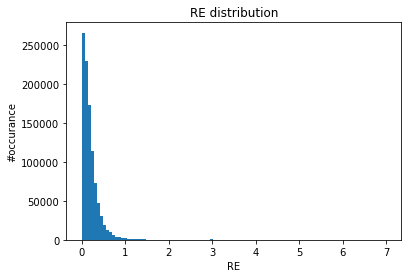

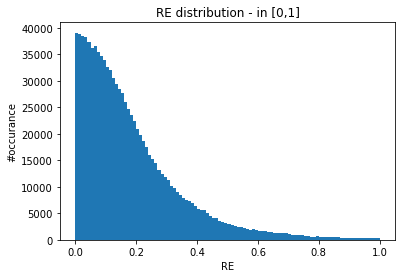

In [148]:
# distribution of relative error in total

relative_errors_total = []
for source in relative_errors.keys():
    relative_errors_total += relative_errors[source]
    #print(source, ': ' ,min(relative_errors[source]))

plt.hist(relative_errors_total, bins = 100)
plt.title('RE distribution')
plt.xlabel('RE')
plt.ylabel('#occurance')
plt.show()

plt.hist([relative_errors_total[i] for i in range(len(relative_errors_total)) if (relative_errors_total[i] < 1.0 and relative_errors_total[i] > 0.0)], bins = 100)
plt.title('RE distribution - in [0,1]')
plt.xlabel('RE')
plt.ylabel('#occurance')
plt.show()

Nodes with the highest REs:  [143, 870, 680, 761, 885, 87, 99, 580, 530, 878]
Highest REs: [0.429, 0.433, 0.438, 0.439, 0.449, 0.454, 0.462, 0.487, 0.51, 0.545]


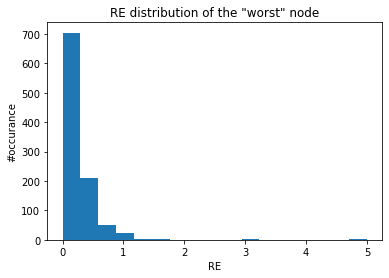

In [149]:
# Is there any extremely bad node???

bad_nodes = sorted(range(len(ARE_per_source)), key=lambda i: ARE_per_source[i])[-10:]
print('Nodes with the highest REs: ', bad_nodes)
print('Highest REs:', [round(ARE_per_source[bad_node], 3) for bad_node in bad_nodes])

plt.hist(relative_errors[bad_nodes[-1]], bins = 17)
plt.title('RE distribution of the "worst" node')
plt.xlabel('RE')
plt.ylabel('#occurance')
plt.show()


# ROADMAP PENNSYLVANIA

In [2]:
RMPS = nx.read_edgelist("roadnetPA.txt", nodetype=int)

In [3]:
#largest connected component
RMPSccs = sorted(nx.connected_components(RMPS), key=len, reverse=True)
RMPScc = RMPS.subgraph(RMPSccs[0])

In [10]:
np.random.seed(1337)
M = 100000
random_nodes = list(RMPS.subgraph(RMPScc).nodes())[0:100000]
G = RMPS.subgraph(random_nodes)
Gccs = sorted(nx.connected_components(G), key=len, reverse=True)
Gcc = G.subgraph(Gccs[0])

In [14]:
mapping = dict(zip(Gcc, range(len(Gcc.nodes))))
Gcc = nx.relabel_nodes(Gcc, mapping)

In [15]:
#preparing inputs for rigel
nodes = list(Gcc.nodes())
N = len(nodes)
landmark_cnt = 100
landmarks = sample(nodes, landmark_cnt)
distance_matrix = [[-1 for i in range(N)] for j in range(landmark_cnt)]
#distance_matrix = dict()
for i in range(landmark_cnt):
    #distance_matrix[i] = dict()
    start_time = time.time()
    print('landmark ', i, ' calculating...')
    node = landmarks[i]
    path_lengths = nx.single_source_shortest_path_length(Gcc, node)
    for j in nodes:
        distance_matrix[i][j] = int(path_lengths[j])
    print("landmark ", i," finished in --- %s seconds ---" % (time.time() - start_time))

landmark  0  calculating...
landmark  0  finished in --- 0.12497186660766602 seconds ---
landmark  1  calculating...
landmark  1  finished in --- 0.11928939819335938 seconds ---
landmark  2  calculating...
landmark  2  finished in --- 0.10878920555114746 seconds ---
landmark  3  calculating...
landmark  3  finished in --- 0.124969482421875 seconds ---
landmark  4  calculating...
landmark  4  finished in --- 0.10830187797546387 seconds ---
landmark  5  calculating...
landmark  5  finished in --- 0.10930895805358887 seconds ---
landmark  6  calculating...
landmark  6  finished in --- 0.1239016056060791 seconds ---
landmark  7  calculating...
landmark  7  finished in --- 0.12364840507507324 seconds ---
landmark  8  calculating...
landmark  8  finished in --- 0.1216423511505127 seconds ---
landmark  9  calculating...
landmark  9  finished in --- 0.10349845886230469 seconds ---
landmark  10  calculating...
landmark  10  finished in --- 0.12020730972290039 seconds ---
landmark  11  calculati

landmark  93  finished in --- 0.12151932716369629 seconds ---
landmark  94  calculating...
landmark  94  finished in --- 0.10935688018798828 seconds ---
landmark  95  calculating...
landmark  95  finished in --- 0.1465311050415039 seconds ---
landmark  96  calculating...
landmark  96  finished in --- 0.13205528259277344 seconds ---
landmark  97  calculating...
landmark  97  finished in --- 0.14548707008361816 seconds ---
landmark  98  calculating...
landmark  98  finished in --- 0.13061928749084473 seconds ---
landmark  99  calculating...
landmark  99  finished in --- 0.12007999420166016 seconds ---


In [93]:
## HERE IT IS THE ORIGINAL DATASET (largest cmoponent)

mapping = dict(zip(RMPScc, range(len(RMPScc.nodes))))
RMPScc = nx.relabel_nodes(RMPScc, mapping)

In [95]:
#preparing inputs for rigel
nodes = list(RMPScc.nodes())
N = len(nodes)
landmark_cnt = 100
landmarks = sample(nodes, landmark_cnt)
distance_matrix = [[-1 for i in range(N)] for j in range(landmark_cnt)]
#distance_matrix = dict()
for i in range(landmark_cnt):
    #distance_matrix[i] = dict()
    start_time = time.time()
    print('landmark ', i, ' calculating...')
    node = landmarks[i]
    path_lengths = nx.single_source_shortest_path_length(RMPScc, node)
    for j in nodes:
        distance_matrix[i][j] = int(path_lengths[j])
    print("landmark ", i," finished in --- %s seconds ---" % (time.time() - start_time))

landmark  0  calculating...
landmark  0  finished in --- 1.6377153396606445 seconds ---
landmark  1  calculating...
landmark  1  finished in --- 1.6166908740997314 seconds ---
landmark  2  calculating...
landmark  2  finished in --- 1.513000726699829 seconds ---
landmark  3  calculating...
landmark  3  finished in --- 1.4783613681793213 seconds ---
landmark  4  calculating...
landmark  4  finished in --- 1.6306395530700684 seconds ---
landmark  5  calculating...
landmark  5  finished in --- 1.629654884338379 seconds ---
landmark  6  calculating...
landmark  6  finished in --- 1.5214283466339111 seconds ---
landmark  7  calculating...
landmark  7  finished in --- 1.5366547107696533 seconds ---
landmark  8  calculating...
landmark  8  finished in --- 1.5249764919281006 seconds ---
landmark  9  calculating...
landmark  9  finished in --- 1.6844770908355713 seconds ---
landmark  10  calculating...
landmark  10  finished in --- 1.5920593738555908 seconds ---
landmark  11  calculating...
lan

landmark  92  finished in --- 1.5907361507415771 seconds ---
landmark  93  calculating...
landmark  93  finished in --- 1.526585578918457 seconds ---
landmark  94  calculating...
landmark  94  finished in --- 1.5927433967590332 seconds ---
landmark  95  calculating...
landmark  95  finished in --- 1.646303415298462 seconds ---
landmark  96  calculating...
landmark  96  finished in --- 1.623143196105957 seconds ---
landmark  97  calculating...
landmark  97  finished in --- 1.6538927555084229 seconds ---
landmark  98  calculating...
landmark  98  finished in --- 1.6443815231323242 seconds ---
landmark  99  calculating...
landmark  99  finished in --- 1.6246025562286377 seconds ---


In [16]:
# write out input for Rigel
mat = np.matrix(distance_matrix)
with open('l_PS_small.txt','wb') as f:
    for line in mat:
        np.savetxt(f, line, fmt='%-4d')
f.close()

In [17]:
# write out input for Rigel
with open('r_PS_small.txt', 'w') as f:
    for node in landmarks:
        f.write('%s\n' % node)
f.close()

In [18]:
# write out input for Rigel
with open('0.ord', 'w') as f:
    for i in range(N):
        if not i in landmarks:
            f.write('%s\n' % i)
f.close()

In [34]:
nx.shortest_path_length(Gcc,44155,65820)

110